#Machine Exercise 6
###Miguel Luis Martinez, Juan Carlos Roldan, Jeryl Salas | AI 221 WZZQ Shannon Batch | University of the Philippines Diliman

Note: Data loaded from one of the submitter's Google Drive filestorage system, hence, the need for the first cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, KernelDensity
import matplotlib.pyplot as plt
import io

## Part 1: Trip Advisor Travel Reviews

In this problem, we will be analyzing a dataset of 980 unique user reviews of Trip Advisor. The dataset has 11 features.Their average feedback
scores on destinations in East Asia. These include art galleries, dance clubs, juice bars, restaurants, museums, resorts, parks, beaches, theaters, and religious institutions.

Our goal is to find patterns in the data to associate reviews to users with similar rating patterns.

In [ ]:
# Load dataset directly from file
X = pd.read_csv("/content/drive/My Drive/MEngAI/AI 221/Datasets/MEX 6/tripadvisor_review.csv")
X["User ID"] = X.index+1 # Replace user ID with an integer starting from index 1
X.set_index("User ID",drop=True,inplace=True) #Ignore user ID in clustering

assert(not(X.isna().any(axis=None)))
print(X.shape)
display(X.head())

(980, 10)


,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
User ID,,,,,,,,,,
1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


We will be dropping the User ID in the reviews as we find that this particular feature is irrelevant and is not needed to inform the clustering algorithm.

### a. Perform K-means clustering on different K values from 2 to 10

First off, we will be performing K-means clustering with various measures of $K$ to understand which value to proceed with for further analysis.

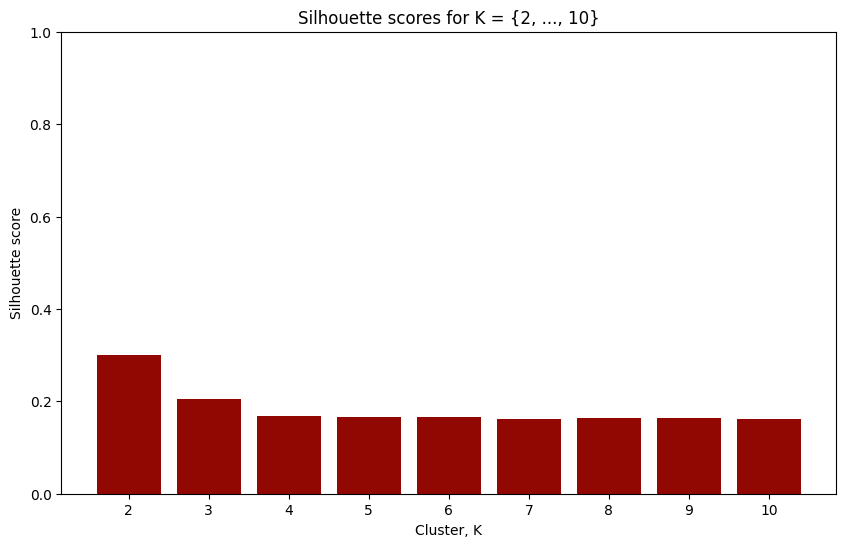

Best score: 0.30085279300986595 (from k = 2)


In [ ]:
silhouette_scores = []
for k in range(2, 11):  # Testing from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    values = silhouette_samples(X, labels)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

x_labels = [x + 2 for x in range(len(silhouette_scores))]
plt.figure(figsize=(10, 6))
plt.bar(x_labels, silhouette_scores, color='#910803')
plt.xlabel('Cluster, K')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(2,11))
plt.ylim(0,1)
plt.title('Silhouette scores for K = {2, ..., 10}')
plt.show()

best_score = max(silhouette_scores)
print('Best score: ' + str(best_score) + ' (from k = ' + str(x_labels[silhouette_scores.index(best_score)]) + ')')

We can see from the graph above that by picking **2 clusters**, we are able to produce the best silhouette score, indicating that with just 2 clusters, the classes are better separated, than in cases where there are more than 2. And in looking at the graph above, we see that beyond the "elbow" located at $k = 3$, there is no longer any significant change in the silhouette scores.

### b. Perform K-means clustering on different K values from 2 to 10 after PCA dimensionality reduction

We now want to improve interpretability and uncover better clustering performance out of our K-means algorithm. We will be projecting the data into 2 variables using Principal Component Analysis (PCA).

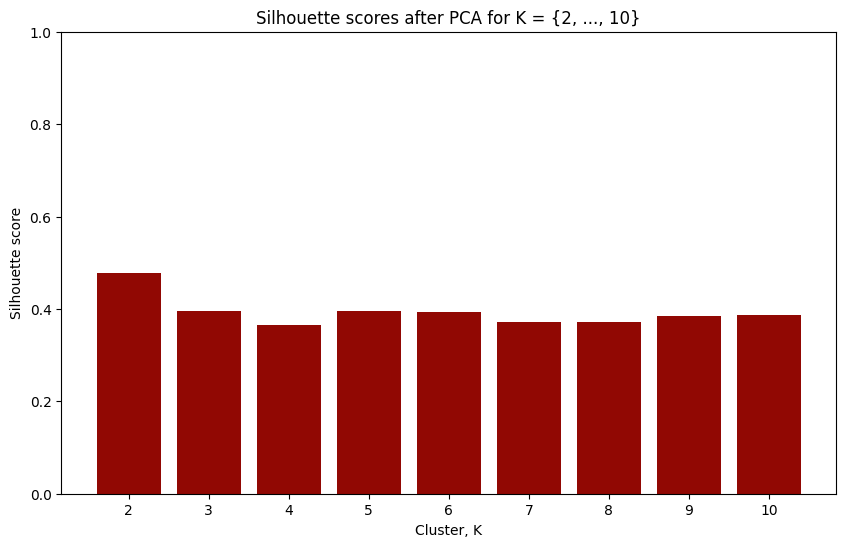

[-0.1764509057984891, -0.19166599475625026, -0.1966810677335131, -0.230474969991512, -0.22677951303755822, -0.2109160340156352, -0.20839588144732818, -0.22110625551670365, -0.22500896360212372]
Best score: 0.47730369880835505 (from k = 2)


In [ ]:
pca = PCA(n_components=2,random_state=73)
X_pca = pca.fit_transform(X)
#repeat previous k-means clustering
silhouette_scores_pca = []
best_score = 0
best_k = 0
best_labels = None
scores = []

for k in range(2, 11):  # Testing from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    values = silhouette_samples(X_pca, labels)
    score = silhouette_score(X_pca, labels)
    silhouette_scores_pca.append(score)
    cluster_labels = kmeans.fit_predict(X_pca)
    if score > best_score:
      best_score = score
      best_k = k
      best_labels = cluster_labels
    scores.append((score, k, cluster_labels))

# Sort scores in descending order.
scores.sort(reverse=True, key=lambda x: x[0])

plt.figure(figsize=(10, 6))
plt.bar([x + 2 for x in range(len(silhouette_scores_pca))], silhouette_scores_pca, color='#910803')
plt.xlabel('Cluster, K')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(2,11))
plt.ylim(0,1)
plt.title('Silhouette scores after PCA for K = {2, ..., 10}')
plt.show()
print([silhouette_scores[i]-silhouette_scores_pca[i] for i in range(len(silhouette_scores))])
print('Best score: ' + str(best_score) + ' (from k = ' + str(best_k) + ')')

In this graph we can see that afterby picking **2 clusters**, we are able to produce the best silhouette score, indicating that with just 2 clusters, the classes are better separated, than in cases where there are more than 2. And in looking at the graph above, we see that beyond the "elbow" located at $k = 3$, there is no longer any significant change in the silhouette scores. We also see the power of PCA in this plot, as the Silhouette scores have improved on their counterparts from part (a).

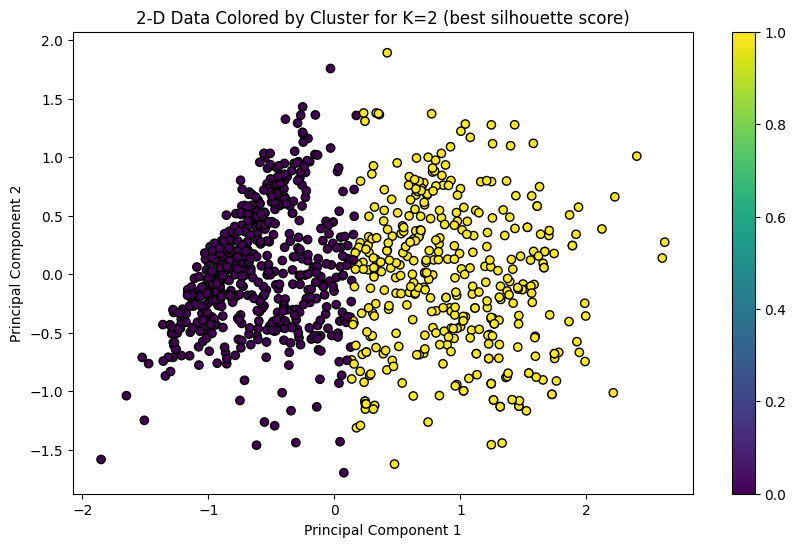

In [ ]:
# Plotting the best clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'2-D Data Colored by Cluster for K={best_k} (best silhouette score)')
plt.colorbar()
plt.show()

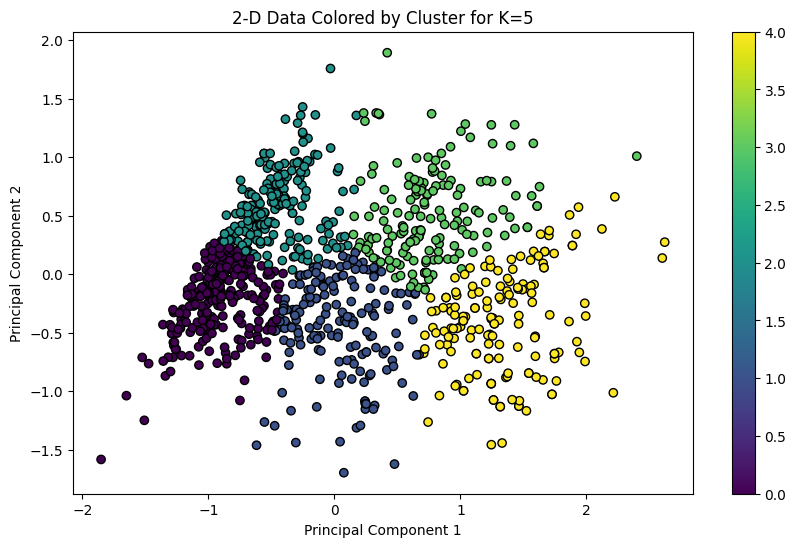

In [ ]:
# Sort for 2nd highest score
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=scores[1][2], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'2-D Data Colored by Cluster for K={scores[1][1]}')
plt.colorbar()
plt.show()

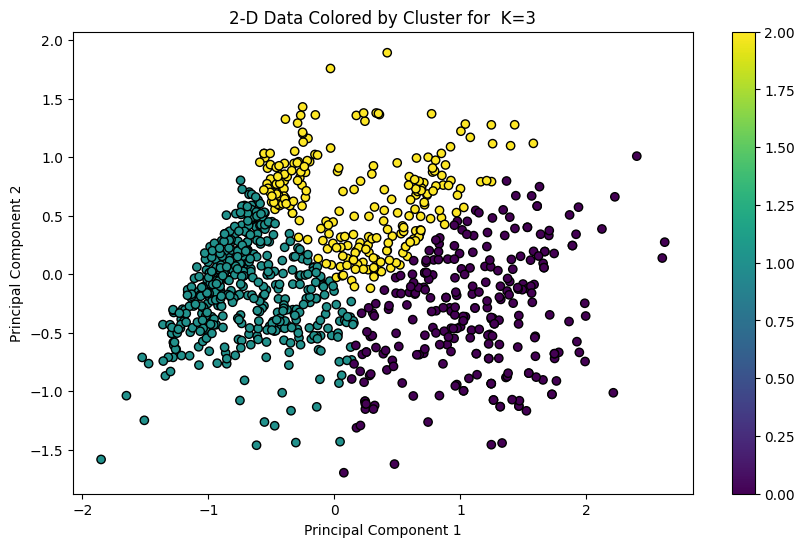

In [ ]:
# Sort for 2nd highest score
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=scores[2][2], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'2-D Data Colored by Cluster for  K={scores[2][1]}')
plt.colorbar()
plt.show()

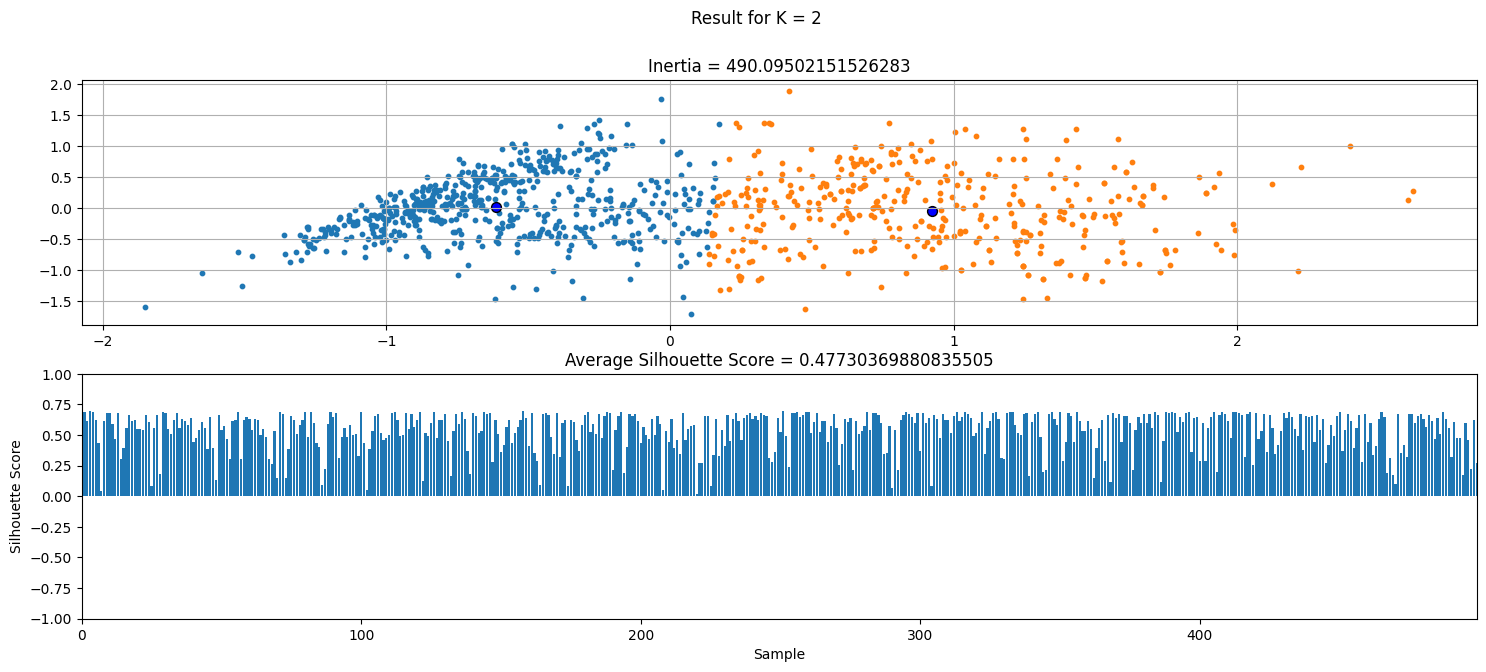

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
values = silhouette_samples(X_pca, labels)
score = silhouette_score(X_pca, labels)


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(18, 7)
fig.suptitle(f"Result for K = {k}")
for i in range(0,k):
    ax1.scatter(X_pca[labels == i,0], X_pca[labels == i,1], s=10)
ax1.scatter(centroids[:,0],centroids[:,1], s=50, color='b', edgecolor='k')
ax1.set_title(f"Inertia = {inertia}")
ax1.grid()
sample = 0
for i in range(0,k):
    sil = values[labels == i]
    ax2.bar(np.arange(sample,sample + sil.size),sil)
    sample = sample + sil.size
ax2.axis([0, 499, -1, 1])
ax2.set_xlabel('Sample')
ax2.set_ylabel('Silhouette Score')
ax2.set_title(f"Average Silhouette Score = {score}")
plt.show()

From here, we see that, in terms of separability and the Silhouette score, $K=2$ does perform marginally better than all values of $K$ greater than 2. Checking the scatter plots themselves also prove that the splitting of the dimensionally reduced dataset down the middle vertical proves to be the best way to separate all the classes.

### c. Use Kernel Density Estimation from the 2-D dataset

Given the outcome of the previous exploration, we did notice that there were a lot of points splaying outwards, even as the clustering seemed very even. We now attempt to analyze the 2-D dataset for outliers.

Kernel Density Estimation (KDE) is a non-parametric way to help us estimate the probability density function of our model. This will help us analyze which parts of our graph shows the points as dense and where the points are sparse. The goal here is that we might eventually decide to remove points in the aforementioned detected sparse regions.

We will be using a confidence level of 95% and plotting the KDE results in 2 dimensions.

Threshold (KDE) = 0.03631271390280283


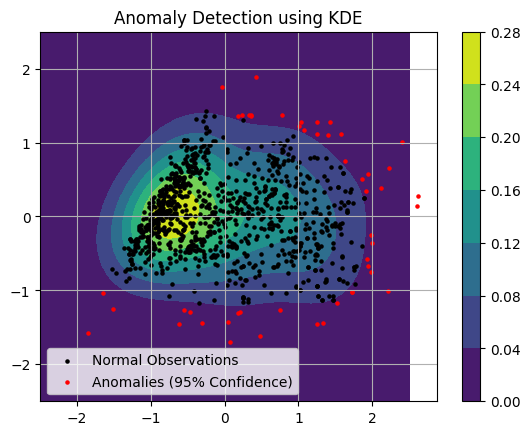

In [ ]:
# Make a meshgrid for plotting surfaces
Xp, Yp = np.meshgrid(np.linspace(-2.5,2.5),np.linspace(-2.5,2.5))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian',bandwidth=0.4).fit(X_pca)
Zp = np.exp(kde.score_samples(XY))
reshaped_Zp = Zp.reshape(Xp.shape)

scores = kde.score_samples(X_pca)
threshold = np.quantile(scores,0.05)
print(f"Threshold (KDE) = {np.exp(threshold)}")

normals = X_pca[scores > threshold,:]
anomals = X_pca[scores <= threshold,:]

cntr = plt.contourf(Xp, Yp, reshaped_Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')
plt.title('Anomaly Detection using KDE')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

In [ ]:
anomaly_indices = np.where(scores < threshold)[0]  # Indices of anomalies in the original data
anomaly_users = X.iloc[anomaly_indices]
print(str(len(anomaly_users)) + " user profiles considered as anomalies:")
print(anomaly_users)

49 user profiles considered as anomalies:
         Category 1  Category 2  Category 3  Category 4  Category 5  \
User ID                                                               
2              1.02        2.20        2.66        0.64        1.42   
17             0.86        1.04        1.76        0.34        0.06   
30             0.64        1.16        3.12        0.45        1.84   
61             1.06        1.92        3.11        0.55        1.46   
67             0.99        1.28        2.32        0.43        0.16   
72             0.83        1.04        2.94        0.96        0.88   
106            0.86        0.88        2.85        0.39        0.42   
115            0.83        1.04        2.94        0.96        0.88   
201            1.06        1.28        2.50        0.62        1.66   
240            2.08        0.48        0.18        0.15        0.10   
248            1.50        1.96        2.08        2.73        1.12   
259            2.22        0.24    

## Conclusion

Given the above data, we were able to identify 49 users considered by our KDE model as anomalies. These are users that need to be studied a bit more. Perhaps they represent user segments previously unexplored. But to sum it up, we were able to use the KDE algorithm to explore other potential segments that would help the destinations understand how to adapt to the other kinds of users represented by these anomalous points.

## Anomaly Detection in a Wastewater Treatment Plant

In this second problem, we have a data set consisting of 527 measurements of 38 process variables in a wastewater treatment plant in Spain. Each row is one day's worth of measurements. These measurements are related to both the process equipment and water quality, all of which are numeric and continuous.

Our goal is to to find days where there are anomalies in the operation of the treatment facility.

### Loading the Dataset


In [ ]:
df = pd.read_csv('/content/drive/My Drive/MEngAI/AI 221/Datasets/MEX 6/water-treatment.data', delimiter=',', header=None)
#remove rows containing missing data
df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
display(df.head())

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,D-5/3/90,35023,3.50,7.9,205,588,192,65.6,4.5,2430,...,1840,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100
1,D-11/3/90,29156,2.50,7.7,206,451,194,69.1,4.5,1249,...,1338,46.1,43.6,92.5,85.6,58.2,92.2,73.8,90.2,99.4
2,D-12/3/90,39246,2.00,7.8,172,506,200,69.0,5.0,1865,...,1616,21.2,59.7,90.8,88.4,66.1,89.0,69.0,86.5,99.6
3,D-13/3/90,42393,0.70,7.9,189,478,230,67.0,5.5,1410,...,1575,0.6,45.8,92.0,11.6,25.7,19.6,36.0,43.0,36.4
4,D-18/3/90,40923,3.50,7.6,146,329,188,57.4,2.5,1300,...,1545,32.7,33.3,90.0,82.6,61.3,87.0,71.4,78.2,99.2


### a. Perform DBSCAN on the 38-feature data set

DBSCAN or Density-Based Spatial Clustering of Applications with Noise is a clustering algorithm that's popular in anomaly detection. We will be using this algorithm to group together points that are closely packed together, and to mark those in sparsely-populated areas as outliers. This is ideal for our use case.

In [ ]:
X = df.iloc[:, 1:].values
scaler = StandardScaler()
X_scl= scaler.fit_transform(X)

Firstly, we want to identify good value of $ϵ$ and `minPts` to use in our model. $ϵ$ defines the radius of the neighborhood around a point. A suitable $ϵ$ should be one that exacts the density of its surrounding area. It shouldn't be too small (which would identify too many of the points as anomalies) or too large (which could merge particularly distinct clusters). With `minPts`, which defines how many points are needed to define a dense region, we might want to select at least 3.

To figure out a good value for $ϵ$, we might want to plot the distance to the k-th nearest neighbor for every point, sorted in descending order. Then, similar to the elbow method, we look for a point in the curve with a sharp bend.

For values for `minPts`, we might want to start with 3 until about 10 to find a good value.

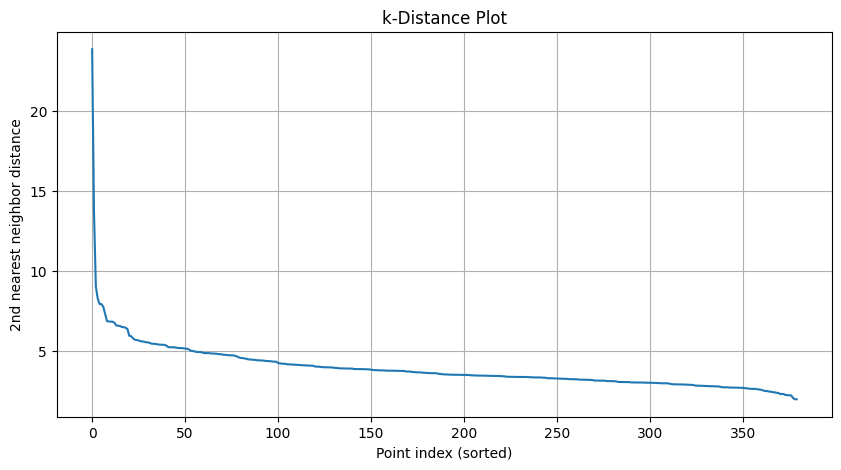

Elbow value is at: 7


In [ ]:
from sklearn.neighbors import NearestNeighbors
import math

# Assuming X_scl is your scaled feature set
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(X_scl)
distances, indices = neigh.kneighbors(X_scl)

# distances[:, 1] contains the distances to the 2nd nearest neighbor
sorted_distances = np.sort(distances[:, 1])[::-1]

plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title('k-Distance Plot')
plt.xlabel('Point index (sorted)')
plt.ylabel('2nd nearest neighbor distance')
plt.grid(True)
plt.show()

# Assume sorted_distances contains the sorted k-distances in descending order
differences = np.diff(sorted_distances, n=1)
# Find the index of the maximum difference
elbow_index = np.argmax(differences)
elbow_value = sorted_distances[elbow_index]
print('Elbow value is at: ' + str(math.ceil(elbow_value)))

Based on the k-distance plot, we will be going with 7 as our value of $ϵ$. Now, we will be determining the right value for `minPts` through trial and error.

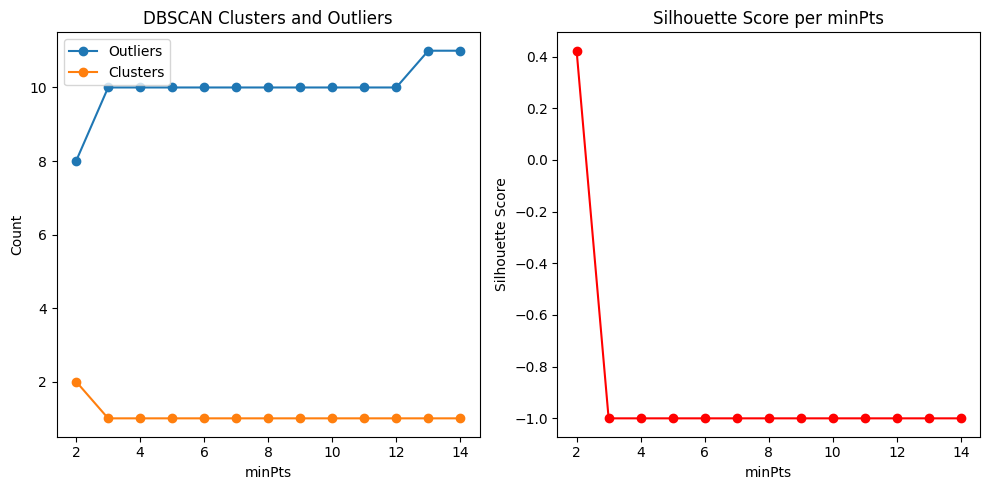

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assume X_scl is your scaled data and eps is already determined
eps = 7  # use your determined value here
minPts_values = range(2, 15)  # example range from 2 to 14
outliers_count = []
clusters_count = []
silhouette_scores = []

for minPts in minPts_values:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(X_scl)

    # Count outliers
    outliers = np.sum(labels == -1)
    outliers_count.append(outliers)

    # Count clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    clusters_count.append(n_clusters)

    # Compute silhouette score if possible
    if n_clusters > 1:
        score = silhouette_score(X_scl, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # invalid case

# Plotting results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(minPts_values, outliers_count, marker='o', label='Outliers')
plt.plot(minPts_values, clusters_count, marker='o', label='Clusters')
plt.title('DBSCAN Clusters and Outliers')
plt.xlabel('minPts')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.plot(minPts_values, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score per minPts')
plt.xlabel('minPts')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


Given the results above, we now redo the DBSCAN method using the selected values of $ϵ$ and `minPts`. In this case, we selected 7 and 3, respectively. We found 10 outliers based on the execution of the algorithm.

Num of outliers:  10
Outliers:
             0      1     2    3    4    5     6     7    8     9   ...    29  \
3     D-13/3/90  42393  0.70  7.9  189  478   230  67.0  5.5  1410  ...  1575   
47     D-5/6/90  39421  1.00  7.9  189  457  1004  25.5   24  1218  ...  1172   
63    D-26/6/90  44198  7.00  7.7  257  667  1016  31.5   22  1478  ...  1378   
108   D-29/4/90  27333  2.00  7.6  238  348   174  64.4  3.5  1110  ...  1256   
128   D-25/7/90  33959  2.00  7.7  235  614   692  29.5  8.0  1589  ...  1625   
216  D-22/10/90  48950  2.50  8.1  109  211   880  13.2  5.5  1745  ...  1495   
276   D-29/1/91  32974  2.60  8.1  311  420   208  69.2  6.5  1474  ...  1466   
278   D-31/1/91  34579  2.50  8.3  261  592   216  71.3  7.5  1663  ...  1848   
300   D-28/5/91  38809  0.75  7.6  179  432  1228  22.8   36  1889  ...  1932   
324   D-29/4/91  35760  1.77  7.6  115  295   182  51.6   25  1400  ...  1316   

       30    31    32    33    34    35    36    37    38  
3     0.6  45.8  

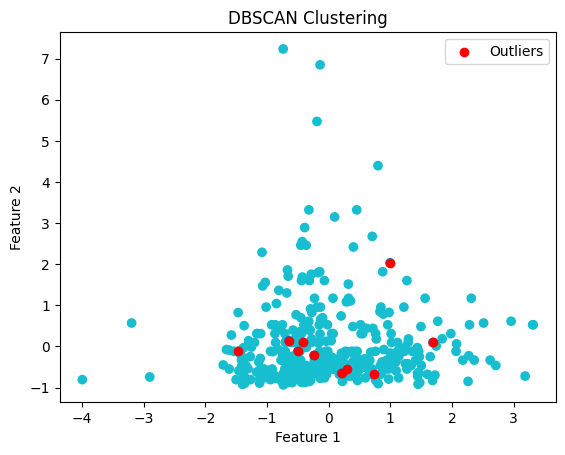

In [ ]:
minPts = 3
eps = 7
dbscan = DBSCAN(eps=eps, min_samples=minPts)
dbscan.fit(X_scl)
labels = dbscan.labels_
outliers_ind = np.where(labels == -1)[0]
outliers = df.iloc[outliers_ind]

print("Num of outliers: ", len(outliers))
print("Outliers:")
print(outliers)

# print(dbscan.labels_)

plt.scatter(X_scl[:, 0], X_scl[:, 1], c=labels, cmap='tab10')
plt.scatter(X_scl[outliers_ind, 0], X_scl[outliers_ind, 1], c='red', label='Outliers')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

### b. Perform anomaly detection methods after dimensionality reduction

We now wish to try out 3 different methods to see how good they fare at extracting anomalies from our dataset. In this section, we will be using the KDE, one-class SVM, and Local Outlier Factors algorithms and comparing them against each other. In all three cases, we will be optimizing their hyperparameters using **GridSearch**.

In [ ]:
pca = PCA(n_components=2)
X_scl_pca = pca.fit_transform(X_scl)

Best bandwidth: 1.8
Threshold (KDE) = 0.0022056690702455767


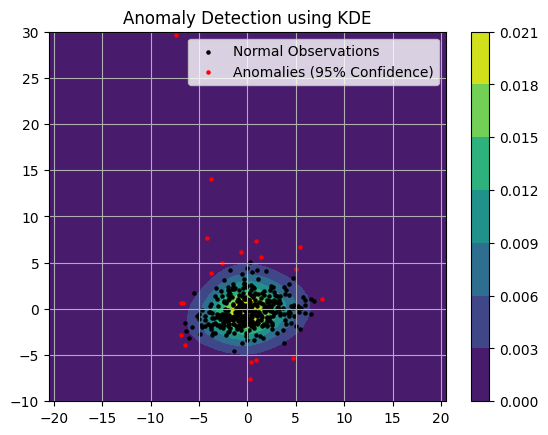

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

# Make a meshgrid for plotting surfaces
Xp, Yp = np.meshgrid(np.linspace(-20.5,20.5),np.linspace(-10,30))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

# Define the parameter range for grid search
params = {'bandwidth': np.linspace(0.1, 2.0, 20)}

grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)  # 5-fold cross-validation
grid.fit(X_scl_pca)
print("Best bandwidth:", grid.best_estimator_.bandwidth)
kde = grid.best_estimator_

Zp = np.exp(kde.score_samples(XY))
Zp = Zp.reshape(Xp.shape)

scores = kde.score_samples(X_scl_pca)
threshold = np.quantile(scores,0.05)
print(f"Threshold (KDE) = {np.exp(threshold)}")

normals = X_scl_pca[scores > threshold,:]
anomals = X_scl_pca[scores <= threshold,:]

cntr = plt.contourf(Xp, Yp, Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')
plt.title('Anomaly Detection using KDE')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

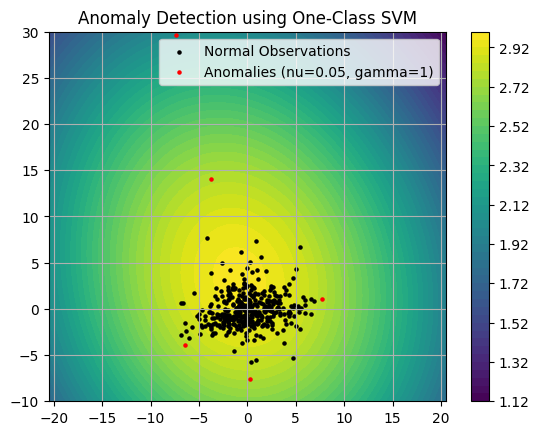

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
import numpy as np
import warnings

# Define the parameter grid
param_grid = {
    'nu': np.linspace(0.01, 0.1, 10),  # adjust the range and number of splits as needed
    'gamma': np.logspace(-3, 3, 7)  # log scale from 0.001 to 1000
}

# Create the OneClassSVM object
ocsvm = OneClassSVM(kernel='rbf')  # default kernel is RBF

# Set up GridSearchCV
grid_search = GridSearchCV(ocsvm, param_grid, cv=5, scoring='accuracy')  # Use scoring method suitable for anomaly detection

# Fit the model
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=UserWarning)
  grid_search.fit(X_scl_pca)  # Ensure your data is scaled appropriately before this step

ocsvm = grid_search.best_estimator_
Zp = ocsvm.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = ocsvm.predict(X_scl_pca)
normals = X_scl_pca[y_pred == 1,:]
anomals = X_scl_pca[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=50, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (nu=0.05, gamma=1)')
plt.title('Anomaly Detection using One-Class SVM')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

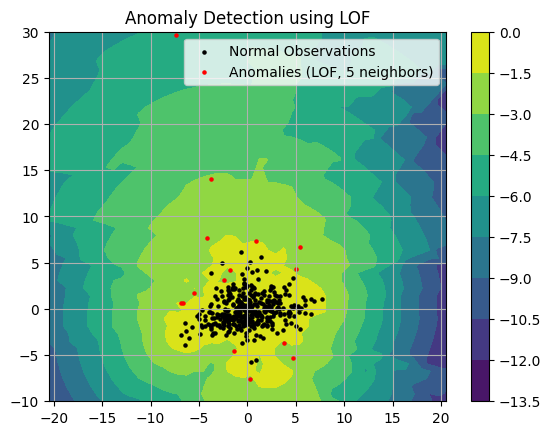

In [ ]:
from sklearn.metrics import make_scorer, silhouette_score

def unsupervised_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    # Silhouette scores require more than one cluster to be present, handle exceptions or adjust as needed
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # worst possible score if only one cluster exists

# Set up GridSearchCV
from sklearn.model_selection import GridSearchCV
lof = LocalOutlierFactor(novelty=True)
param_grid = {'n_neighbors': np.arange(5, 50, 5)}

grid_search = GridSearchCV(lof, param_grid, cv=5, scoring=make_scorer(unsupervised_scorer, greater_is_better=True))
# Fit the model
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=UserWarning)
  grid_search.fit(X_scl_pca)

lof = grid_search.best_estimator_
Zp = lof.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = lof.predict(X_scl_pca)
normals = X_scl_pca[y_pred == 1,:]
anomals = X_scl_pca[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=10, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (LOF, 5 neighbors)')
plt.title('Anomaly Detection using LOF')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

Given the plots above for each of the 3 methods, we now want to compare their silhouette scores.

## Performance evaluation on anomaly detection

In [ ]:
from sklearn.metrics import silhouette_score

# Generate binary labels from the models based on their own criteria
ocsvm_labels = np.where(ocsvm.predict(X_scl_pca) == -1, 0, 1)
kde_labels = np.where(scores <= threshold, 0, 1)  # Threshold from KDE
lof_labels = np.where(lof.predict(X_scl_pca) == -1, 0, 1)

# Calculate silhouette scores
ocsvm_silhouette = silhouette_score(X_scl_pca, ocsvm_labels)
kde_silhouette = silhouette_score(X_scl_pca, kde_labels)
lof_silhouette = silhouette_score(X_scl_pca, lof_labels)

print(f"Silhouette Score for One-Class SVM: {ocsvm_silhouette}")
print(f"Silhouette Score for KDE: {kde_silhouette}")
print(f"Silhouette Score for LOF: {lof_silhouette}")


Silhouette Score for One-Class SVM: 0.7036217818043703
Silhouette Score for KDE: 0.547521139608795
Silhouette Score for LOF: 0.5517619543865819


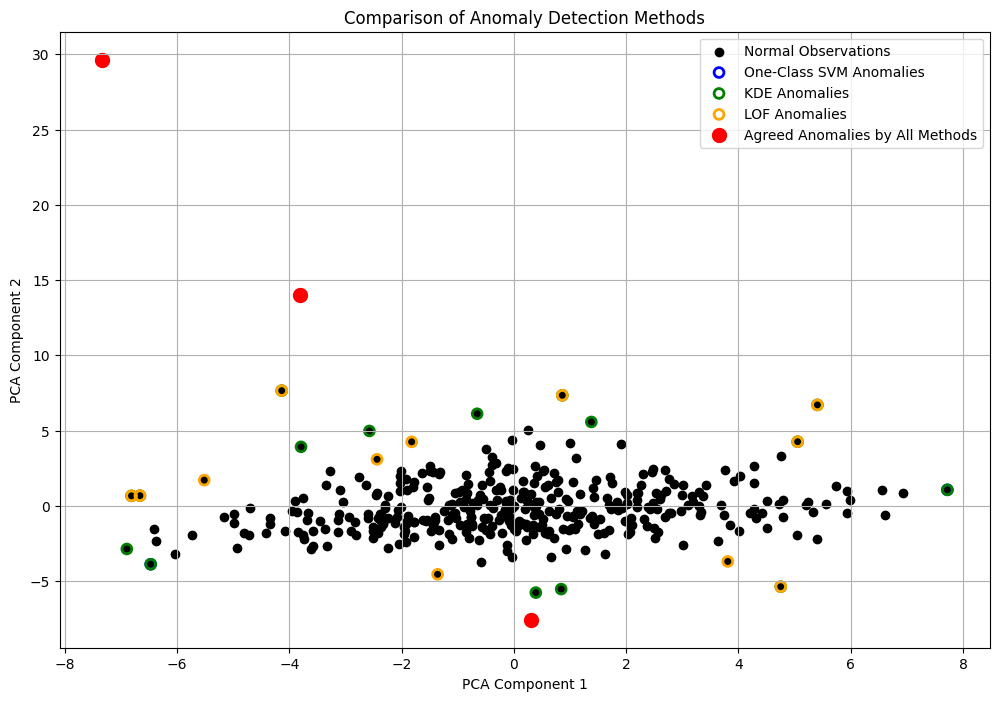

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting all points, you can adjust this part based on your actual 'normals' and 'anomals' definition
plt.scatter(X_scl_pca[:, 0], X_scl_pca[:, 1], color='k', label='Normal Observations')

# Anomalies detected by each model
plt.scatter(X_scl_pca[ocsvm_labels == 0, 0], X_scl_pca[ocsvm_labels == 0, 1], s=50, edgecolors='blue', facecolors='none', linewidth=2, label='One-Class SVM Anomalies')
plt.scatter(X_scl_pca[kde_labels == 0, 0], X_scl_pca[kde_labels == 0, 1], s=50, edgecolors='green', facecolors='none', linewidth=2, label='KDE Anomalies')
plt.scatter(X_scl_pca[lof_labels == 0, 0], X_scl_pca[lof_labels == 0, 1], s=50, edgecolors='orange', facecolors='none', linewidth=2, label='LOF Anomalies')

# Highlighting overlaps
# Assuming 'anomals' is defined based on all method agreement; this may need more specific handling to find intersections
plt.scatter(X_scl_pca[(ocsvm_labels == 0) & (kde_labels == 0) & (lof_labels == 0), 0], X_scl_pca[(ocsvm_labels == 0) & (kde_labels == 0) & (lof_labels == 0), 1], s=100, color='red', label='Agreed Anomalies by All Methods')

plt.title('Comparison of Anomaly Detection Methods')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

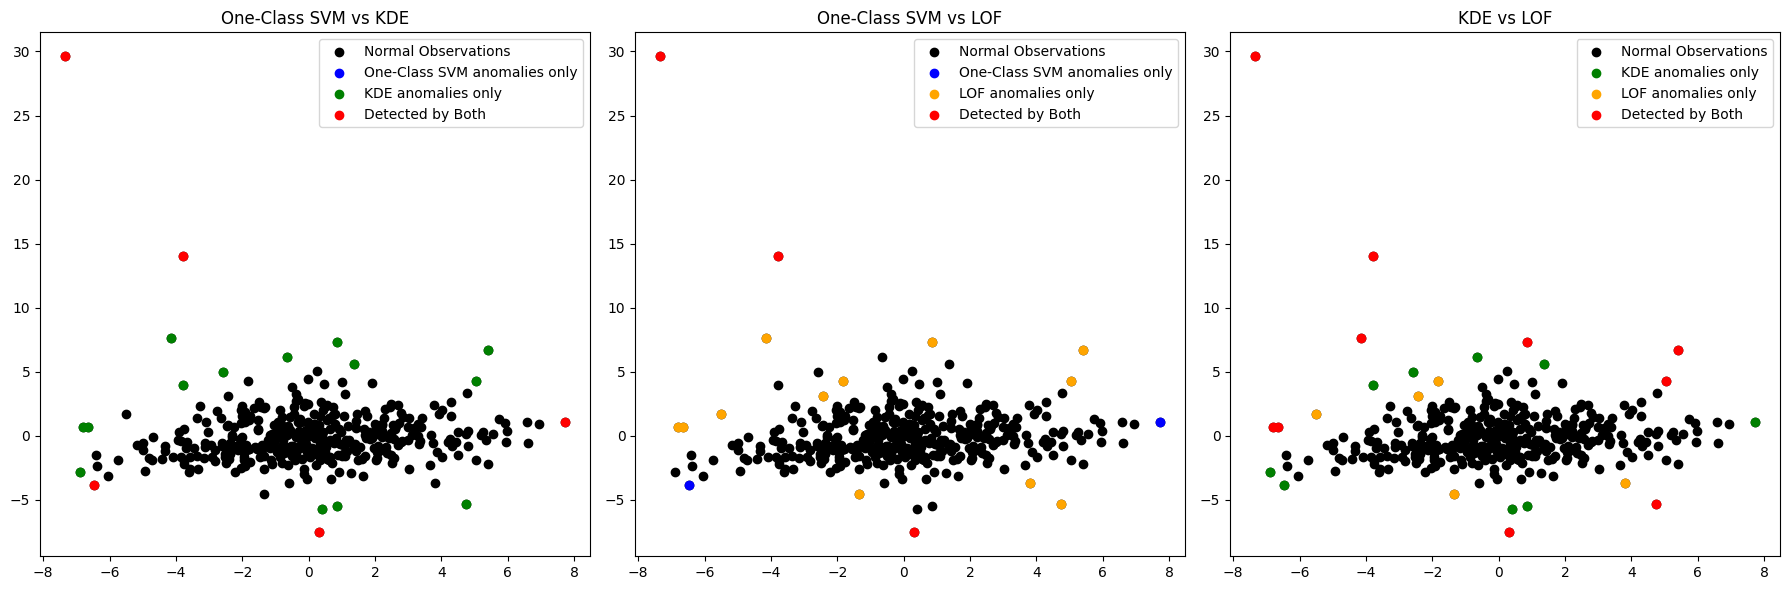

In [ ]:
import matplotlib.pyplot as plt

# Assuming ocsvm_labels, kde_labels, and lof_labels are already defined as binary arrays where -1/0 represents anomalies
plt.figure(figsize=(18, 6))

# Pairwise comparison between One-Class SVM and KDE
plt.subplot(1, 3, 1)
plt.scatter(X_scl_pca[:, 0], X_scl_pca[:, 1], color='k', label='Normal Observations')
plt.scatter(X_scl_pca[(ocsvm_labels == 0) & (kde_labels != 0), 0], X_scl_pca[(ocsvm_labels == 0) & (kde_labels != 0), 1], color='blue', label='One-Class SVM anomalies only')
plt.scatter(X_scl_pca[(ocsvm_labels != 0) & (kde_labels == 0), 0], X_scl_pca[(ocsvm_labels != 0) & (kde_labels == 0), 1], color='green', label='KDE anomalies only')
plt.scatter(X_scl_pca[(ocsvm_labels == 0) & (kde_labels == 0), 0], X_scl_pca[(ocsvm_labels == 0) & (kde_labels == 0), 1], color='red', label='Detected by Both')
plt.title('One-Class SVM vs KDE')
plt.legend()

# Pairwise comparison between One-Class SVM and LOF
plt.subplot(1, 3, 2)
plt.scatter(X_scl_pca[:, 0], X_scl_pca[:, 1], color='k', label='Normal Observations')
plt.scatter(X_scl_pca[(ocsvm_labels == 0) & (lof_labels != 0), 0], X_scl_pca[(ocsvm_labels == 0) & (lof_labels != 0), 1], color='blue', label='One-Class SVM anomalies only')
plt.scatter(X_scl_pca[(ocsvm_labels != 0) & (lof_labels == 0), 0], X_scl_pca[(ocsvm_labels != 0) & (lof_labels == 0), 1], color='orange', label='LOF anomalies only')
plt.scatter(X_scl_pca[(ocsvm_labels == 0) & (lof_labels == 0), 0], X_scl_pca[(ocsvm_labels == 0) & (lof_labels == 0), 1], color='red', label='Detected by Both')
plt.title('One-Class SVM vs LOF')
plt.legend()

# Pairwise comparison between KDE and LOF
plt.subplot(1, 3, 3)
plt.scatter(X_scl_pca[:, 0], X_scl_pca[:, 1], color='k', label='Normal Observations')
plt.scatter(X_scl_pca[(kde_labels == 0) & (lof_labels != 0), 0], X_scl_pca[(kde_labels == 0) & (lof_labels != 0), 1], color='green', label='KDE anomalies only')
plt.scatter(X_scl_pca[(kde_labels != 0) & (lof_labels == 0), 0], X_scl_pca[(kde_labels != 0) & (lof_labels == 0), 1], color='orange', label='LOF anomalies only')
plt.scatter(X_scl_pca[(kde_labels == 0) & (lof_labels == 0), 0], X_scl_pca[(kde_labels == 0) & (lof_labels == 0), 1], color='red', label='Detected by Both')
plt.title('KDE vs LOF')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion

Based on the results above, we see that OCSVM had a bigger Silhouette score than the other 2 methods, suggesting that the One-Class SVM has much more effectively distinguished between normal and anomalous points. The anomalies detected by the SVM are likely well separated from the bulk of your data, indicating clear demarcation of anomalies.

It appears that OCSVM might be the go-to model in these cases, but we might also want to explore other changes to the other models. For instance, in KDE, we could explore if changing the "bandwidth" parameter could help. Likewise, for LOF, we could examine the value for "n_neighbors". It's also helped that we can examine the points as we did in the subplots above, to inspect any overlaps visually. Understanding the overlaps helps us understand on the surface how the algorithms perform with respect to each other.